In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import cv2
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dropout

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.preprocessing import LabelEncoder

Mounted at /content/drive


In [ ]:
# Offside videos directory
offside_dir = '/content/drive/MyDrive/Football/offside'

# Foul videos directory
foul_dir = '/content/drive/MyDrive/Football/foul'

In [ ]:
def extract_and_preprocess_frames(video_path, output_dir, target_size=(240, 240)):
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Get the total number of frames
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Set the frame rate
    frame_rate = int(cap.get(cv2.CAP_PROP_FPS))

    # Loop through each frame
    for i in range(total_frames):
        # Read the frame
        ret, frame = cap.read()

        if not ret:
            break

        # Resize the frame to the target size
        frame_resized = cv2.resize(frame, target_size)

        # Save the preprocessed frame
        frame_name = f"frame_{i+1}.jpg"  # You can change the format if needed
        frame_path = os.path.join(output_dir, frame_name)
        cv2.imwrite(frame_path, frame_resized)

    # Release the video capture object
    cap.release()

# Extract and preprocess frames from offside videos
for offside_video in os.listdir(offside_dir):
    video_path = os.path.join(offside_dir, offside_video)
    output_offside_dir = os.path.join('/content/drive/MyDrive/Football/preprocessed_frames/offside', os.path.splitext(offside_video)[0])
    extract_and_preprocess_frames(video_path, output_offside_dir)

# Extract and preprocess frames from foul videos
for foul_video in os.listdir(foul_dir):
    video_path = os.path.join(foul_dir, foul_video)
    output_foul_dir = os.path.join('/content/drive/MyDrive/Football/preprocessed_frames/foul', os.path.splitext(foul_video)[0])
    extract_and_preprocess_frames(video_path, output_foul_dir)


In [ ]:
# Constants
preprocessed_frames_dir = '/content/drive/MyDrive/Football/preprocessed_frames'
offside_dir = os.path.join(preprocessed_frames_dir, 'offside')
foul_dir = os.path.join(preprocessed_frames_dir, 'foul')

# Function to load and label the frames
def load_frames(directory, label):
    frames = []
    labels = []
    for subdir in os.listdir(directory):
        sub_dir_path = os.path.join(directory, subdir)
        if os.path.isdir(sub_dir_path):
            for frame_file in os.listdir(sub_dir_path):
                frame_path = os.path.join(sub_dir_path, frame_file)
                frame = cv2.imread(frame_path)
                frames.append(frame)
                labels.append(label)
    return frames, labels

# Load frames and labels for offside and foul
offside_frames, offside_labels = load_frames(offside_dir, 0)
foul_frames, foul_labels = load_frames(foul_dir, 1)

# Combine frames and labels
frames = offside_frames + foul_frames
labels = offside_labels + foul_labels

# Convert lists to NumPy arrays
frames = np.array(frames)
labels = np.array(labels)

# Shuffle the dataset
np.random.seed(42)
shuffle_indices = np.random.permutation(len(frames))
frames = frames[shuffle_indices]
labels = labels[shuffle_indices]

# Split the dataset into training and testing sets
train_frames, test_frames, train_labels, test_labels = train_test_split(frames, labels, test_size=0.2, random_state=42)

# Encode the labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

In [ ]:

# Load the pre-trained VGG16 model without the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(240, 240, 3))

# Freeze the base model's layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the base model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(24, activation='relu'))
model.add(Dropout(0.5))  # Adding Dropout regularization
model.add(Dense(12, activation='relu'))
model.add(Dropout(0.5))  # Adding Dropout regularization
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])



58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
batch_size = 32
epochs = 10

# Calculate the number of steps per epoch
steps_per_epoch = len(train_frames) // batch_size

# Train the model using mini-batches
history=model.fit(train_frames, train_labels_encoded, batch_size=batch_size, epochs=epochs,
          steps_per_epoch=steps_per_epoch, validation_data=(test_frames, test_labels_encoded))

Epoch 1/10
112/112 [==============================] - 1952s 17s/step - loss: 1.1856 - accuracy: 0.7374 - val_loss: 0.0591 - val_accuracy: 0.9500
Epoch 2/10
112/112 [==============================] - 1983s 18s/step - loss: 0.4293 - accuracy: 0.7822 - val_loss: 0.0217 - val_accuracy: 0.9856
Epoch 3/10
112/112 [==============================] - 1917s 17s/step - loss: 0.3856 - accuracy: 0.7836 - val_loss: 0.0250 - val_accuracy: 0.9733
Epoch 4/10
112/112 [==============================] - 1905s 17s/step - loss: 0.3438 - accuracy: 0.8108 - val_loss: 0.0231 - val_accuracy: 0.9856
Epoch 5/10
112/112 [==============================] - 1902s 17s/step - loss: 0.3532 - accuracy: 0.8366 - val_loss: 0.0191 - val_accuracy: 0.9856
Epoch 6/10
112/112 [==============================] - 1903s 17s/step - loss: 0.3237 - accuracy: 0.8170 - val_loss: 0.0114 - val_accuracy: 0.9867
Epoch 7/10
112/112 [==============================] - 1902s 17s/step - loss: 0.3087 - accuracy: 0.8285 - val_loss: 0.0117 - val_ac

In [ ]:
# # # Define the path to save the model
# model_path = '/content/drive/MyDrive/Football/model.h5'

# # Save the model
# model.save(model_path)

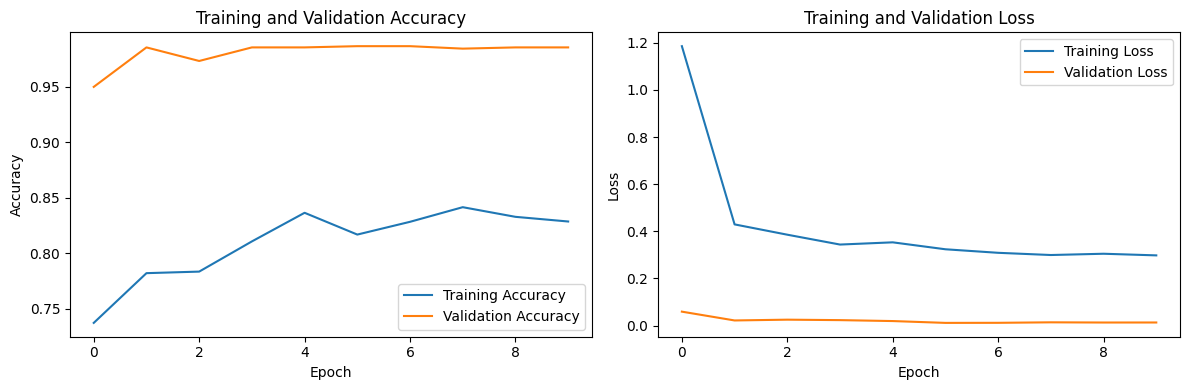

In [ ]:
import matplotlib.pyplot as plt

# Get the training and validation accuracy values
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Get the training and validation loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the accuracy curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot the loss curves
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_frames, test_labels_encoded)

# Print the test accuracy and test loss
print("Test Accuracy:", test_accuracy)
print("Test Loss:", test_loss)



29/29 [==============================] - 389s 13s/step - loss: 0.0131 - accuracy: 0.9856
Test Accuracy: 0.9855555295944214
Test Loss: 0.013062275014817715


29/29 [==============================] - 401s 14s/step


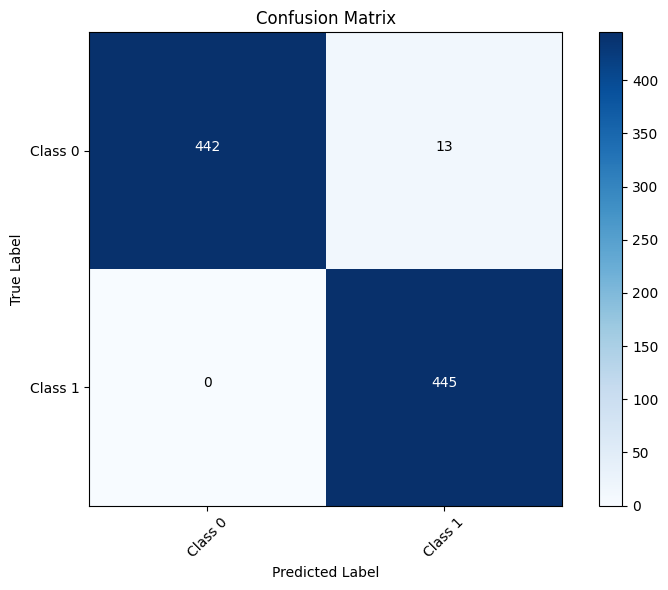

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Make predictions on the test set
predictions = model.predict(test_frames)
predicted_labels = np.round(predictions).flatten()

# Create the confusion matrix
confusion_mat = confusion_matrix(test_labels_encoded, predicted_labels)

# Define the class labels
class_labels = ['Class 0', 'Class 1']

# Define a function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    # Add text annotations
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plot_confusion_matrix(confusion_mat, classes=class_labels)
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Generate classification report
class_report = classification_report(test_labels_encoded, predicted_labels, target_names=class_labels)
print(class_report)

              precision    recall  f1-score   support

     Class 0       1.00      0.97      0.99       455
     Class 1       0.97      1.00      0.99       445

    accuracy                           0.99       900
   macro avg       0.99      0.99      0.99       900
weighted avg       0.99      0.99      0.99       900

